# Support identification: TSOC vs GR

Compressed Sensing (CS) is based on the hypothesis that the input is sparse in some domain, where with sparse we mean a signals whose components are mostly null and only a small minority is different from zero. However, real-world signals are hardly ever sparse due to different reasons as for example the presence of noise in acquisition. Hence, signals cannot be considered sparse but **compressible**, i.e., most components are negligible compared with a small minority which have a significantly higher magnitude.

In the literature, there exist a family of CS decoders [[1]](#TBCAS2020) which reconstruct the input from the mesurement by leveraging the knowledge of the **support** which indicates the position of the non-null coefficients in the sparse representation of the input. 

However, we can define a signal support only when the signal is sparse. In [[2]](#JETCAS2020), we extended the definition of support to compressible signals as the support that, given a CS encoder, maximizes the quality of reconstruction. This definition of support for compressible signals has the disadvantage to depend on how the signal is compressed into measurements, i.e., it depends on the CS encoder.

Recently, we explored the possibility to define a support of a compressible signal independetly from encoding. The idea consists in considering the components with highest magnitude that retain a certain fraction of energy $\eta$. We call this method GR (intials of Gabriele Ravaglia, the student who worked on this first)

This notebook aims to compare the TSOC method (the one proposed in [[2]](#JETCAS2020)) to the recently considered GR method. We expect the former to outperform the latter but depending on the differences there may be cases in which the GR method is preferrable.


In [1]:
%matplotlib widget

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [3]:
import os
import sys

import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import neurokit2 as nk

import multiprocessing as mp

from itertools import product

from scipy import linalg
from numpy import random

from tqdm import tqdm


In [ ]:
# import of local modules
root = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(0, os.path.join(root, 'src'))

from dataset import dataset_dir
from dataset.synthetic_ecg import generate_ecg
from cs.wavelet_basis import wavelet_basis
from cs import CompressedSensing, generate_sensing_matrix
from cs.utils import compute_rsnr

## Dataset

We use a synthetic Electrocardiography (ECG) dataset, the same employed in [[1]](#TBCAS2020) and [[2]](#JETCAS2020). The dataset has been generated with [ECGSYN](https://physionet.org/content/ecgsyn/1.0.0/) (which implements the algorithm reported in [[3]](#McSharry_TBME2003)).

The heart-beat rate is randomly set using an uniform distribution between 60 and 100 beat/minute. We generate chunks of 2s with a 256sample/s sampling frequency, that are split into windows
of n subsequent samples.

In [5]:
N = 10_000              # number of ECG traces
n = 128                 # length of an ECG trace
fs = 256                # sampling rate
heart_rate = (60, 100)  # min and max heart rate
isnr = 45               # signal-to-noise ratio in dB (35)
ecg_seed = 0            # random seed for ECG generation
processes = 24          # number of processes for multiprocessing

data_name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
            f'_isnr={isnr}_seed={ecg_seed}'
data_path = os.path.join(dataset_dir, data_name + '.pkl')
if os.path.exists(data_path):
    with open(data_path, 'rb') as f:
        X = pickle.load(f)
else:
    X = generate_ecg(
        length=n, 
        num_traces=N,
        heart_rate=heart_rate, 
        sampling_rate=fs, 
        snr=isnr, 
        random_state=ecg_seed,
        verbose=True,
        processes=processes,
    )
    with open(data_path, 'wb') as f:
        pickle.dump(X, f)

folder = os.path.join(dataset_dir, data_name)
if not os.path.exists(folder):
    os.mkdir(folder)

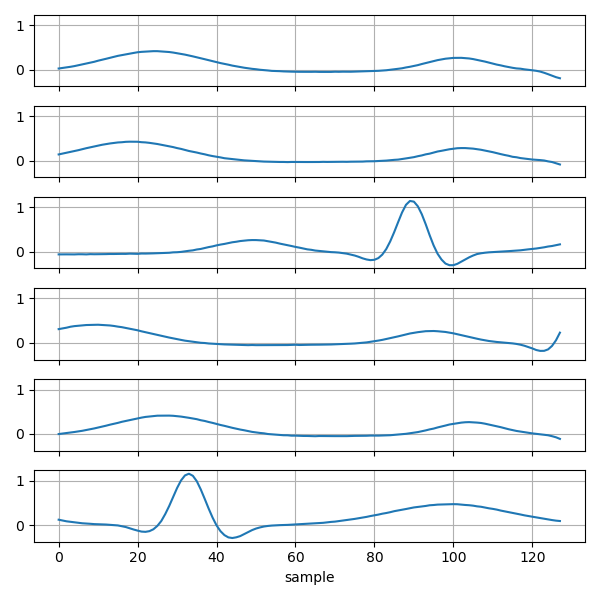

In [6]:
num_plot = 6

fig, axs = plt.subplots(num_plot, 1, figsize=(6, 1.*num_plot), 
                        sharex='all', sharey='all')
for i, (ax, x) in enumerate(zip(axs, X)):
    ax.plot(x)
    ax.grid()
axs[-1].set(xlabel='sample')
fig.tight_layout()

As in [[1]](#TBCAS2020) and [[2]](#JETCAS2020) and firstly proposed in [[4]](#TBCAS2015), we employ the Symmlet-6 family of the orthogonal Wavelet functions as a Sparsity basis.

In [7]:
basis = 'sym6'

D = wavelet_basis(n, basis, level=2)

## GR Algorithm

Identify signal support with GR algortithm which identify the support by considering the smallest subsets of compontest that retains a given energy fraction.

### Experiments

The experiments measure the Resconstruction Signal to Ratio (RSNR) in different settings. Different settings involve:
- data: the amount of noise injected into the synthetic ECG signal
- support identification method: the amount of energy fraction used to determine the support
- compressed sensing system: the amount of measurements (`m`), the type of encoder (standard or rakeness-based), and whether the sensing matrix is orthogonalized or not.

In [24]:
# Experiment parameters

# ---- data ----
isnr_list = (25, 35, 45)  # Intrinsic Signal-to-Noise Ratio

# ---- support ---- 
method = 'GR' # support identification algorithm
eta_list = (
    0.9, 
    0.93,    0.95,    0.97,    0.98,    0.985,    0.99, 
    0.993,   0.995,   0.997,   0.998,   0.9985,   0.999, 
    0.9993,  0.9995,  0.9997,  0.9998,  0.99985,  0.9999, 
    0.99993, 0.99995, 0.99997, 0.99998, 0.999985, 0.99999,
)  # energy fractions

# ---- compressed sensing ---- 
m_list = (16, 32, 48, 64)  # number of measurements
mode_list = ('standard', 'rakeness')  # CS mode: standard, rakeness
orth_list = (False, True)  # whether orthogonalize sensing matrix or not

# ---- rakeness ----
loc = .25
corr_name = '96af96a7ddfcb2f6059092c250e18f2a'

The experiments are conducted through the script `compute_rsnr_GR.py`. Here we load and visulize the results.

In [35]:
rsnr = []
for isnr in isnr_list:

    # select folder corresponding to the selected dataset
    data_name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
                f'_isnr={isnr}_seed={ecg_seed}'
    rsnr_dir = os.path.join(dataset_dir, data_name)
    
    for mode in mode_list:
        
        # load RSNRs
        rsnr_name = f'rsnr_method={method}_mode={mode}.pkl'
        rsnr_path = os.path.join(rsnr_dir, rsnr_name)
        if not os.path.exists(rsnr_path):
            continue
        tmp = pd.read_pickle(rsnr_path)

        if mode == 'rakeness':
            # select rakeness configuration indicated above
            tmp = tmp.xs((corr_name, loc), level=('corr', 'loc'), axis=1)

        # select the only columns indicated above
        tmp = tmp.reindex(columns=eta_list, level='eta')
        tmp = tmp.reindex(columns=m_list, level='m')
        tmp = tmp.reindex(columns=orth_list, level='orth')

        # create new multiindex levels for isnr and mode
        tmp = pd.concat(
            [tmp], keys=[mode], names=['mode'] + tmp.columns.names, axis=1)
        tmp = pd.concat(
            [tmp], axis=1, keys=[isnr], names=['isnr'] + tmp.columns.names)
        
        rsnr.append(tmp)

rsnr = pd.concat(rsnr, axis=1)

In [36]:
# compute statistics
_rsnr = rsnr.stack('seed')
rsnr_med = _rsnr.median().unstack(('isnr', 'mode', 'm', 'orth'))
rsnr_q25 = _rsnr.quantile(.25).unstack(('isnr', 'mode', 'm', 'orth'))
rsnr_q75 = _rsnr.quantile(.75).unstack(('isnr', 'mode', 'm', 'orth'))
eta_best = rsnr_med.idxmax()

rsnr_med.max().unstack('m')

m                           16         32         48         64
isnr mode     orth                                             
25   rakeness True   13.546318  21.279790  24.535379  26.569476
     standard False  12.479297  19.610394  22.776465  24.890877
              True   12.594393  19.916347  23.300175  25.674729
35   rakeness False  13.756619  27.254478  31.980331  34.649891
              True   14.290950  27.797431  32.582662  35.371469
     standard False  13.713094  26.038251  30.792780  33.651344
              True   13.796146  26.303492  31.295602  34.429387
45   rakeness True   14.368042  31.702866  40.022348  43.831418
     standard True   13.947969  30.249917  38.601504  42.816118

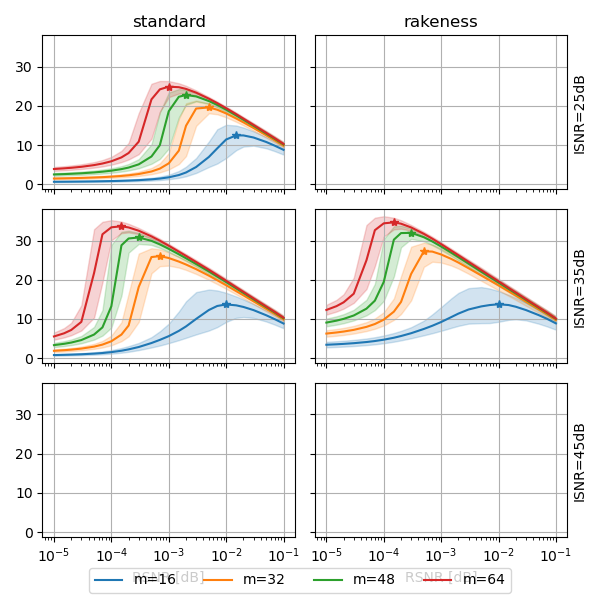

In [18]:
orth = False

ncols = len(mode_list)
nrows = len(isnr_list)

fig, axs = plt.subplots(nrows, ncols, figsize=(6, 2*nrows), 
                        sharex='all', sharey='all', squeeze=False)
index = 1 - rsnr_med.index
for _axs, isnr in zip(axs, isnr_list):
    for ax, mode in zip(_axs, mode_list):
        _rsnr_med = rsnr_med.xs(
            (isnr, mode, orth), level=('isnr', 'mode', 'orth'), axis=1)
        for i, m in enumerate(_rsnr_med.columns):
            ax.plot(index, rsnr_med[isnr, mode, m, orth], label=f'm={m}')
            ax.fill_between(
                index, 
                rsnr_q25[isnr, mode, m, orth], 
                rsnr_q75[isnr, mode, m, orth], 
                color=f'C{i}', alpha=0.2)
            ax.plot(
                [1 - eta_best[isnr, mode, m, orth]], 
                [rsnr_med.max()[isnr, mode, m, orth]], 
                marker='*', color=f'C{i}')
        ax.set(xscale='log')
        ax.grid()

for ax, mode in zip(axs[0], mode_list): ax.set(title=mode)
for ax, isnr in zip(axs[:, -1], isnr_list): 
    ax.text(1.05, 0.5, f'ISNR={isnr}dB', rotation='vertical', 
            va='center', ha='center', transform=ax.transAxes)
for ax in axs[-1]: ax.set(xlabel='RSNR [dB]')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=max(4, len(m_list)))
fig.tight_layout()


- the higher the number of mesurements `m` (i.e., lower the compression ratio) the higher the energy fraction $\eta$ that gives the best performance. This is intuitive as a higher compression leaves less room for components.

- As the noise energy increases (lower ISNR), the lower the the energy fraction $\eta$ that gives the best performance. This behavior is expected as with a higher noise swallows more components so that a fewer number contributes for the signal reconstruction.


## TSOC Algorithm

Identify signal support with TSOC algortithm which identify the support as the one maximizing the quality of reconstruction.

### working principle

TSOC algorithm is a greedy algorithm that finds a proxy of the support that maximizes the RSNR. 

The algorithm is iterative and builds the support considering one component at a time ordered from the highest to lowest magnitude up to the `m`-th components, where `m` is the number of measurements (i.e., the dimension of the compressed signal `y`). At each iteration, the algorithms includes a new component, reconstructs the input signal, and measures the quality in terms of RSNR. 

Following the iterative procedure, the algorithm selects the support as the one that gave the highest RSNR.

Here, we show how TSOC algorithm finds the support `s` of a signal `x` for different values of `m` (number of measurements) and sensing matrices `A` generated with different seeds.

In [21]:
i_sample = 0  # index of the ECG sample
m_list = (8, 16, 32, 48, 64)
seed_list = np.arange(100)

# load ecg data
with open(data_path, 'rb') as f:
    X = pickle.load(f)
x = X[i_sample]

rsnr = pd.DataFrame(
    index=1 + np.arange(max(m_list)),
    columns=pd.MultiIndex.from_product(
        (m_list, seed_list), names=('m', 'seed')),
    dtype=float,
)
for seed in tqdm(seed_list):

    A = generate_sensing_matrix((np.max(m_list), n), seed=seed)

    for m in m_list:
        # find and sort sparse representation of x
        xi = D.T @ x
        argsort_xi = np.argsort(np.abs(xi))[::-1]
        
        # compute measurements
        cs = CompressedSensing(A[:m], D)
        y = cs.encode(x)

        # apply algorithm
        s = np.zeros(cs.n, dtype=bool)
        for i in range(m + 10):
            s[argsort_xi[i]] = True  # update support
            x_hat = cs.decode(y, s=s)  # reconstruct input
            rsnr.loc[i + 1, (m, seed)] = compute_rsnr(x, x_hat)

100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


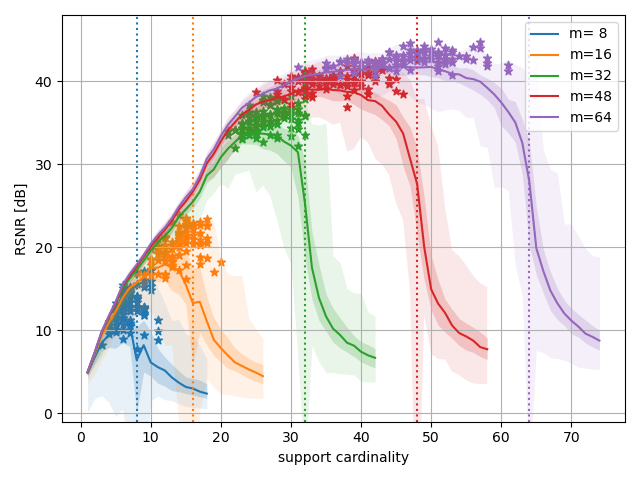

In [25]:
fig, ax = plt.subplots()
for i, m in enumerate(m_list):
    color = f'C{i}'
    _rsnr = rsnr.xs(m, level='m', axis=1).dropna().T
    ax.plot(_rsnr.median(), label=f'm={m:2d}', color=color)
    ax.fill_between(_rsnr.columns, _rsnr.quantile(.25), _rsnr.quantile(.75), 
                    alpha=0.2, color=color, lw=0)
    ax.fill_between(_rsnr.columns, _rsnr.min(), _rsnr.max(), 
                    alpha=0.1, color=color, lw=0)
    ax.scatter(_rsnr.idxmax(axis=1), _rsnr.max(axis=1), c=color, marker='*')
    ax.axvline(m, color=color, ls=':')
ax.set(xlabel='support cardinality', ylabel='RSNR [dB]', ylim=(-1, 48))
ax.grid()
ax.legend()
fig.tight_layout()

### Experiments

The experiments measure the Resconstruction Signal to Ratio (RSNR) in different settings. Different settings involve:
- data: the amount of noise injected into the synthetic ECG signal
- compressed sensing system: the amount of measurements (`m`), the type of encoder (standard or rakeness-based), and whether the sensing matrix is orthogonalized or not.

In [ ]:
# Experiment parameters

# ---- data ----
isnr_list = (25, 35, 45)  # Intrinsic Signal-to-Noise Ratio

# ---- support ----
method = 'TSOC'  # support identification algorithm

# ---- compressed sensing ----
m_list = (16, 32, 48, 64)  # number of measurements
mode_list = ('standard', 'rakeness')  # CS mode: standard, rakeness
orth_list = (False, True)  # whether orthogonalize sensing matrix or not

# ---- rakeness ----
loc = .25
corr_name = '96af96a7ddfcb2f6059092c250e18f2a'

The experiments are conducted through the script `compute_rsnr_TSOC.py`. Here we load and visulize the results.

In [ ]:
rsnr = []
for isnr in isnr_list:
    data_name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
                f'_isnr={isnr}_seed={ecg_seed}'
    for mode in mode_list:
        rsnr_name = f'rsnr_method={method}_mode={mode}.pkl'
        rsnr_path = os.path.join(dataset_dir, data_name, rsnr_name)
        if not os.path.exists(rsnr_path):
            continue
        tmp = pd.read_pickle(rsnr_path)
        if mode == 'rakeness':
            tmp = tmp.xs((corr_name, loc), level=('corr', 'loc'), axis=1)
        # tmp = tmp.xs(orth, level='orth', axis=1)
        tmp = tmp.reindex(columns=m_list, level='m')
        tmp = pd.concat(
            [tmp], keys=[mode], names=['mode'] + tmp.columns.names, axis=1)
        tmp = pd.concat(
            [tmp], keys=[isnr], names=['isnr'] + tmp.columns.names, axis=1)
        rsnr.append(tmp)
rsnr = pd.concat(rsnr, axis=1)

In [21]:
_rsnr = rsnr.stack('seed')
rsnr_med = _rsnr.median()

rsnr_med.unstack('m')

m                           16         32         48         64
isnr mode     orth                                             
25   rakeness True   15.571108  22.753675  25.384903  27.508285
     standard True   14.487343  21.328009  24.291980  26.720979
35   rakeness False  16.178982  29.409348  33.373081  35.811455
              True   16.525738  29.662693  33.721161  36.344081
     standard False  15.836389  27.843882  32.146806  34.877954
              True   15.892789  28.031608  32.522725  35.476445
45   rakeness True   16.622824  34.084793  41.583933  44.942091
     standard True   16.084519  32.487712  40.298295  44.013530

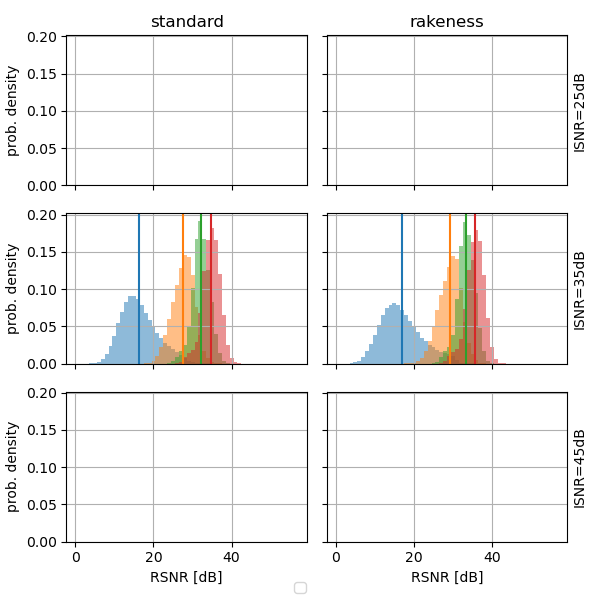

In [22]:
orth = False

ncols, nrows = len(mode_list), len(isnr_list)
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 2*nrows), 
                        sharex='all', sharey='all', squeeze=False)
ebin_width = 1.
ebin_min = np.round(np.min(rsnr.values)) - ebin_width/2
ebin_max = np.round(np.max(rsnr.values)) + ebin_width/2
ebins = np.arange(ebin_min, ebin_max, ebin_width)
for _axs, isnr in zip(axs, isnr_list):
    for ax, mode in zip(_axs, mode_list):
        __rsnr = _rsnr.xs(
            (isnr, mode, orth), level=('isnr', 'mode', 'orth'), axis=1)
        for i, m in enumerate(__rsnr.columns.unique('m')):
            color = f'C{i}'
            ax.hist(__rsnr[m], bins=ebins, density=True, 
                    alpha=0.5, label=f'm={m}', color=color)
            ax.axvline(__rsnr[m].mean(), color=color)
            # ax.axvline(__rsnr[m].median(), color=color)
        ax.grid(True)
    _axs[0].set(ylabel='prob. density')


for ax, mode in zip(axs[0], mode_list): ax.set(title=mode)
for ax, isnr in zip(axs[:, -1], isnr_list): 
    ax.text(1.05, 0.5, f'ISNR={isnr}dB', rotation='vertical', 
            va='center', ha='center', transform=ax.transAxes)
for ax in axs[-1]: ax.set(xlabel='RSNR [dB]')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=max(4, len(m_list)))
fig.tight_layout()


## TSOC2 Algorithm

### working principle


**TOFIX**

TSOC algorithm is a greedy algorithm that finds a proxy of the support that maximizes the RSNR. 

The algorithm is iterative and builds the support considering one component at a time ordered from the highest to lowest magnitude up to the `m`-th components, where `m` is the number of measurements (i.e., the dimension of the compressed signal `y`). At each iteration, the algorithms includes a new component, reconstructs the input signal, and measures the quality in terms of RSNR. 

Following the iterative procedure, the algorithm selects the support as the one that gave the highest RSNR.

Here, we show how TSOC algorithm finds the support `s` of a signal `x` for different values of `m` (number of measurements) and sensing matrices `A` generated with different seeds.

In [21]:
i_sample = 0  # index of the ECG sample
m_list = (8, 16, 32, 48, 64)
seed_list = np.arange(20)
delta_m = 10

# load ecg data
with open(data_path, 'rb') as f:
    X = pickle.load(f)
x = X[i_sample]

rsnr = pd.DataFrame(
    index=1 + np.arange(max(m_list) + delta_m),
    columns=pd.MultiIndex.from_product(
        (m_list, seed_list), names=('m', 'seed')),
    dtype=float,
)
for seed in tqdm(seed_list):

    A = generate_sensing_matrix((np.max(m_list), n), seed=seed)

    for m in m_list:        
        # compute measurements
        cs = CompressedSensing(A[:m], D)
        y = cs.encode(x)

        # apply algorithm
        _m = min(cs.n, cs.m + delta_m)
        s1 = np.zeros(cs.n, dtype=bool) 
        for i in range(_m):
            rsnr2 = -np.inf * np.ones(cs.n, dtype=float)
            for j in np.where(~s1)[0]:  
                s2 = s1.copy()
                s2[j] = True
                x_hat = cs.decode_with_support(y, s2)
                rsnr2[j] = compute_rsnr(x, x_hat)
            s_idx = np.argmax(rsnr2)
            s1[s_idx] = True
            rsnr.loc[i + 1, (m, seed)] = rsnr2[s_idx]
            # print(rsnr.loc[i + 1, (m, seed)])

  0%|          | 0/20 [00:03<?, ?it/s]


KeyboardInterrupt: 


KeyboardInterrupt



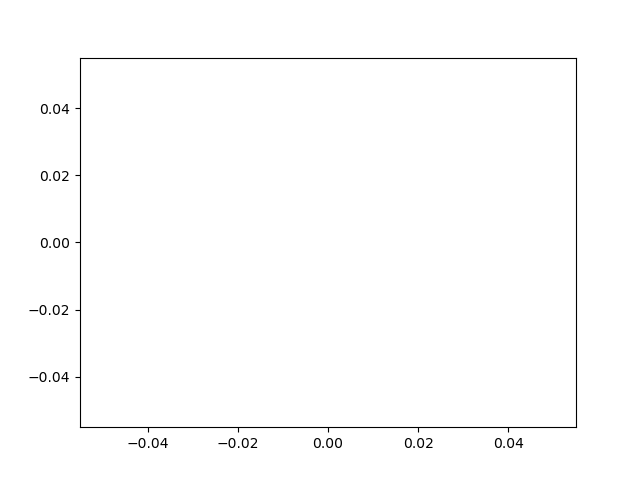

In [22]:
fig, ax = plt.subplots()
for i, m in enumerate(m_list):
    color = f'C{i}'
    _rsnr = rsnr.xs(m, level='m', axis=1).dropna().T
    ax.plot(_rsnr.median(), label=f'm={m:2d}', color=color)
    ax.fill_between(_rsnr.columns, _rsnr.quantile(.25), _rsnr.quantile(.75), 
                    alpha=0.2, color=color, lw=0)
    ax.fill_between(_rsnr.columns, _rsnr.min(), _rsnr.max(), 
                    alpha=0.1, color=color, lw=0)
    ax.scatter(_rsnr.idxmax(axis=1), _rsnr.max(axis=1), c=color, marker='*')
    ax.axvline(m, color=color, ls=':')
ax.set(xlabel='support cardinality', ylabel='RSNR [dB]')
ax.grid()
ax.legend()
fig.tight_layout()

### Experiments

The experiments measure the Resconstruction Signal to Ratio (RSNR) in different settings. Different settings involve:
- data: the amount of noise injected into the synthetic ECG signal
- compressed sensing system: the amount of measurements (`m`), the type of encoder (standard or rakeness-based), and whether the sensing matrix is orthogonalized or not.

In [48]:
# Experiment parameters

# ---- data ----
isnr_list = (35, )  # Intrinsic Signal-to-Noise Ratio

# ---- support ----
method = 'TSOC2'  # support identification algorithm

# ---- compressed sensing ----
m_list = (16, 32, 48, 64)  # number of measurements
mode_list = ('standard', )  # CS mode: standard, rakeness
orth_list = (True, )  # whether orthogonalize sensing matrix or not


The experiments are conducted through the script `compute_rsnr_TSOC.py`. Here we load and visulize the results.

In [49]:
rsnr = []
for isnr in isnr_list:
    data_name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
                f'_isnr={isnr}_seed={ecg_seed}'
    for mode in mode_list:
        rsnr_name = f'rsnr_method={method}_mode={mode}.pkl'
        rsnr_path = os.path.join(dataset_dir, data_name, rsnr_name)
        if not os.path.exists(rsnr_path):
            continue
        tmp = pd.read_pickle(rsnr_path)
        if mode == 'rakeness':
            tmp = tmp.xs((corr_name, loc), level=('corr', 'loc'), axis=1)
        tmp = tmp.reindex(columns=m_list, level='m')
        tmp = pd.concat(
            [tmp], keys=[mode], names=['mode'] + tmp.columns.names, axis=1)
        tmp = pd.concat(
            [tmp], keys=[isnr], names=['isnr'] + tmp.columns.names, axis=1)
        rsnr.append(tmp)
rsnr = pd.concat(rsnr, axis=1)

In [51]:
_rsnr = rsnr.stack('seed')
rsnr_med = _rsnr.median()

rsnr_med.unstack('m')

,,m,16,32,48,64
isnr,mode,orth,,,,
35,standard,True,14.983202,27.435815,33.229439,36.376377


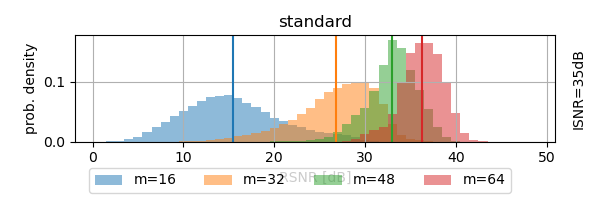

In [54]:
orth = True

ncols, nrows = len(mode_list), len(isnr_list)
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 2*nrows), 
                        sharex='all', sharey='all', squeeze=False)
ebin_width = 1.
ebin_min = np.round(np.nanmin(rsnr.values)) - ebin_width/2
ebin_max = np.round(np.nanmax(rsnr.values)) + ebin_width/2
ebins = np.arange(ebin_min, ebin_max, ebin_width)
for _axs, isnr in zip(axs, isnr_list):
    for ax, mode in zip(_axs, mode_list):
        __rsnr = _rsnr.xs(
            (isnr, mode, orth), level=('isnr', 'mode', 'orth'), axis=1)
        for i, m in enumerate(__rsnr.columns.unique('m')):
            color = f'C{i}'
            ax.hist(__rsnr[m], bins=ebins, density=True, 
                    alpha=0.5, label=f'm={m}', color=color)
            ax.axvline(__rsnr[m].mean(), color=color)
            # ax.axvline(__rsnr[m].median(), color=color)
        ax.grid(True)
    _axs[0].set(ylabel='prob. density')


for ax, mode in zip(axs[0], mode_list): ax.set(title=mode)
for ax, isnr in zip(axs[:, -1], isnr_list): 
    ax.text(1.05, 0.5, f'ISNR={isnr}dB', rotation='vertical', 
            va='center', ha='center', transform=ax.transAxes)
for ax in axs[-1]: ax.set(xlabel='RSNR [dB]')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=max(4, len(m_list)))
fig.tight_layout()


## References


1. <a name="TBCAS2020"></a> M. Mangia, L. Prono, A. Marchioni, F. Pareschi, R. Rovatti and G. Setti, "Deep Neural Oracles for Short-Window Optimized Compressed Sensing of Biosignals," in IEEE Transactions on Biomedical Circuits and Systems, vol. 14, no. 3, pp. 545-557, June 2020, doi: [10.1109/TBCAS.2020.2982824](www.doi.org/10.1109/TBCAS.2020.2982824)
2. <a name="JETCAS2020"></a> L. Prono, M. Mangia, A. Marchioni, F. Pareschi, R. Rovatti and G. Setti, "Deep Neural Oracle With Support Identification in the Compressed Domain," in IEEE Journal on Emerging and Selected Topics in Circuits and Systems, vol. 10, no. 4, pp. 458-468, Dec. 2020, doi: [10.1109/JETCAS.2020.3039731](www.doi.org/10.1109/JETCAS.2020.3039731)
3. <a name="McSharry_TBME2003"></a> P. E. McSharry, G. D. Clifford, L. Tarassenko and L. A. Smith, "A dynamical model for generating synthetic electrocardiogram signals," in IEEE Transactions on Biomedical Engineering, vol. 50, no. 3, pp. 289-294, March 2003, doi: [10.1109/TBME.2003.808805](www.doi.org/10.1109/TBME.2003.808805)
4. <a name="TBCAS2015"></a> F. Pareschi, P. Albertini, G. Frattini, M. Mangia, R. Rovatti and G. Setti, "Hardware-Algorithms Co-Design and Implementation of an Analog-to-Information Converter for Biosignals Based on Compressed Sensing," in IEEE Transactions on Biomedical Circuits and Systems, vol. 10, no. 1, pp. 149-162, Feb. 2016, doi: [10.1109/TBCAS.2015.2444276](www.doi.org/10.1109/TBCAS.2015.2444276)